<a href="https://colab.research.google.com/github/MrBigBrane/Machine-Learning/blob/main/CIFAR10_Autoencoder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# import libraries
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
import copy
from sklearn.model_selection import train_test_split

# for importing data
import torchvision
import torchvision.transforms as T
from torch.utils.data import TensorDataset,DataLoader,random_split

import matplotlib.pyplot as plt
import matplotlib_inline.backend_inline
matplotlib_inline.backend_inline.set_matplotlib_formats('svg')

In [ ]:
# use GPU if available
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [ ]:
# Define the transformations to apply to the data
transform = T.Compose(
    [T.ToTensor(),
     T.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

In [ ]:
# import the data and simultaneously apply the transform
trainset = torchvision.datasets.CIFAR10(root='./data', train=True,  download=True, transform=transform)
testset  = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

# transform to dataloaders
batchsize    = 32
train_loader = DataLoader(trainset,batch_size=batchsize,shuffle=True,drop_last=True)
test_loader  = DataLoader(testset, batch_size=batchsize)

100%|██████████| 170M/170M [00:04<00:00, 35.1MB/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [ ]:
train_loader.dataset.data.shape

(50000, 32, 32, 3)

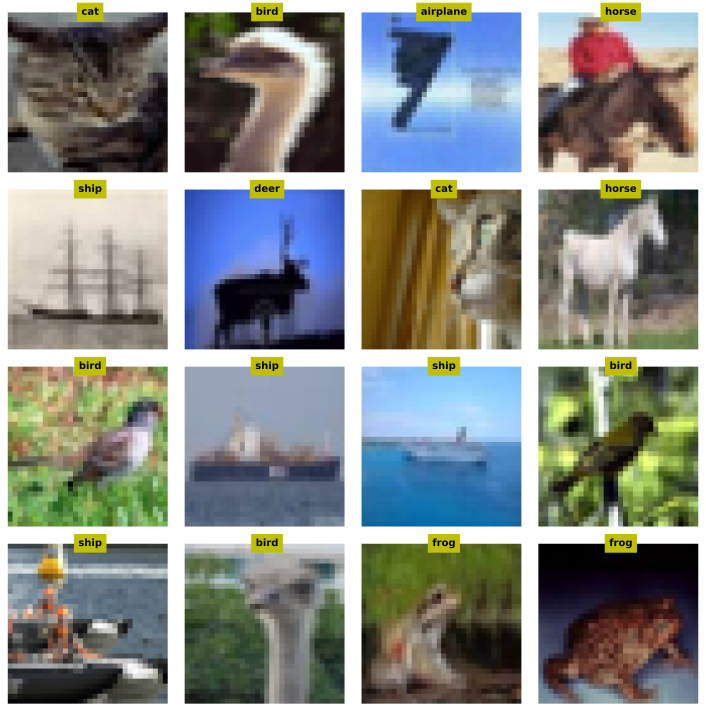

In [ ]:
# inspect a few random images

X,y = next(iter(train_loader))

fig,axs = plt.subplots(4,4,figsize=(10,10))

for (i,ax) in enumerate(axs.flatten()):

  # extract that image (need to transpose it back to 32x32x3)
  pic = X.data[i].numpy().transpose((1,2,0))
  pic = pic/2 + .5 # undo normalization

  # and its label
  label = trainset.classes[y[i]]

  # and show!
  ax.imshow(pic)
  ax.text(16,0,label,ha='center',fontweight='bold',color='k',backgroundcolor='y')
  ax.axis('off')

plt.tight_layout()
plt.show()

In [ ]:
# create a class for the model
def makeTheNet(printtoggle=False):

  class cifarnet(nn.Module):
    def __init__(self,printtoggle):
      super().__init__()

      # print toggle
      self.print = printtoggle

      # encoding layer
      self.enc = nn.Sequential(
          nn.Conv2d(3,16,4,padding=1, stride=2),
          nn.ReLU(),
          nn.BatchNorm2d(16),
          nn.Conv2d(16,32,4,padding=1, stride=2),
          nn.ReLU(),
          nn.BatchNorm2d(32),
          nn.Conv2d(32,64,4,padding=1,stride=2),
          nn.ReLU(),
          nn.BatchNorm2d(64),
          )

      # decoding layer
      self.dec = nn.Sequential(
          nn.ConvTranspose2d(64,32,4,padding=1,stride=2),
          nn.ReLU(),
          nn.BatchNorm2d(32),
          nn.ConvTranspose2d(32,16,4,padding=1,stride=2),
          nn.ReLU(),
          nn.BatchNorm2d(16),
          nn.ConvTranspose2d(16,3,4,padding=1,stride=2),
          )

    def forward(self,x):
      return self.dec( self.enc(x) )

  # create the model instance
  net = cifarnet(printtoggle)

  # loss function
  lossfun = nn.MSELoss()

  # optimizer
  optimizer = torch.optim.Adam(net.parameters(),lr=.001,weight_decay=1e-5)

  return net,lossfun,optimizer

In [ ]:
# test the model with one batch
net,lossfun,optimizer = makeTheNet(True)

X,y = next(iter(train_loader))
print(y.shape)
yHat = net(X)

# check size of output
print('\nOutput size:')
print(yHat.shape)

# now compute the loss
loss = lossfun(yHat,X)
print(' ')
print('Loss:')
print(loss)

torch.Size([32])

Output size:
torch.Size([32, 3, 32, 32])
 
Loss:
tensor(0.7198, grad_fn=<MseLossBackward0>)


In [ ]:
# a function that trains the model

def function2trainTheModel():

  # number of epochs
  numepochs = 10

  # create a new model
  net,lossfun,optimizer = makeTheNet()

  # send the model to the GPU
  net.to(device)

  # initialize losses
  trainLoss = torch.zeros(numepochs)
  testLoss   = torch.zeros(numepochs)


  # loop over epochs
  for epochi in range(numepochs):

    # loop over training data batches
    net.train() # switch to train mode
    batchLoss = []
    for X,y in train_loader:

      # push data to GPU
      X = X.to(device)
      y = y.to(device)

      # forward pass and loss
      yHat = net(X)
      loss = lossfun(yHat,X)

      # backprop
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      # loss and accuracy from this batch
      batchLoss.append(loss.item())
    # end of batch loop...

    # and get average losses and accuracies across the batches
    trainLoss[epochi] = np.mean(batchLoss)

    #### test performance (here done in batches!)
    net.eval() # switch to test mode
    batchLoss = []
    for X,y in test_loader:

      # push data to GPU
      X = X.to(device)
      y = y.to(device)

      # forward pass and loss
      with torch.no_grad():
        yHat = net(X)
        loss = lossfun(yHat,X)

      # loss and accuracy from this batch
      batchLoss.append(loss.item())
    # end of batch loop...

    # and get average losses and accuracies across the batches
    testLoss[epochi] = np.mean(batchLoss)

  # end epochs

  # function output
  return trainLoss,testLoss,net

In [ ]:
# test the model on a bit of data
trainLoss,testLoss,net = function2trainTheModel()

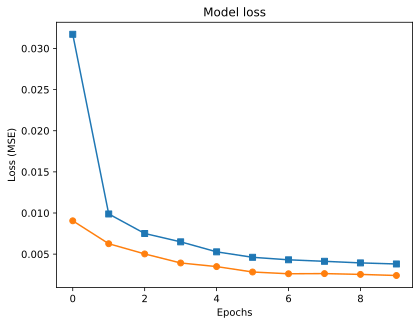

In [ ]:
plt.plot(trainLoss,'s-',label='Train')
plt.plot(testLoss,'o-',label='Test')
plt.xlabel('Epochs')
plt.ylabel('Loss (MSE)')
plt.title('Model loss')

plt.show()

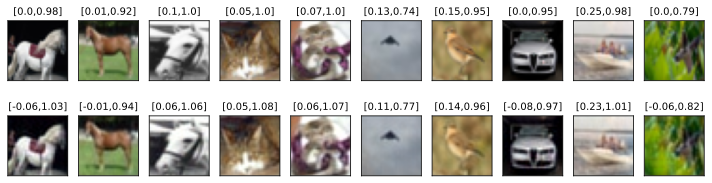

In [ ]:
# extract X,y from test dataloader
X,y = next(iter(test_loader))
X = X.to(device) # push data to GPU
y = y.to(device) # push data to GPU
yHat = net(X)

# pick some examples at random to show
randex = np.random.choice(len(X),size=10,replace=False)

# visualize some images
fig,axs = plt.subplots(2,10,figsize=(10, 3))

for i in range(len(randex)):
  ax1 = axs[0, i]  # Assign ax1 and ax2 for each image and its prediction
  ax2 = axs[1, i]

  # Extract and display original image
  I = np.squeeze(X[randex[i], :, :, :]).cpu()
  I = (I.detach().numpy() + 1) / 2
  ax1.imshow(I.transpose(1, 2, 0))
  ax1.set_xticks([])
  ax1.set_yticks([])
  ax1.set_title("[" + str(np.min(I).round(2)) + "," + str(np.max(I).round(2)) + "]", fontsize=10)

  # Extract and display prediction image
  I = np.squeeze(yHat[randex[i], :, :, :]).cpu()
  I = (I.detach().numpy() + 1) / 2
  ax2.imshow(I.transpose(1, 2, 0))
  ax2.set_xticks([])
  ax2.set_yticks([])
  ax2.set_title("[" + str(np.min(I).round(2)) + "," + str(np.max(I).round(2)) + "]", fontsize=10)

plt.tight_layout()

plt.show()